#**1) Importing the necessary libraries**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import cv2
from google.colab.patches import cv2_imshow

#**2) Image Preprocessing**

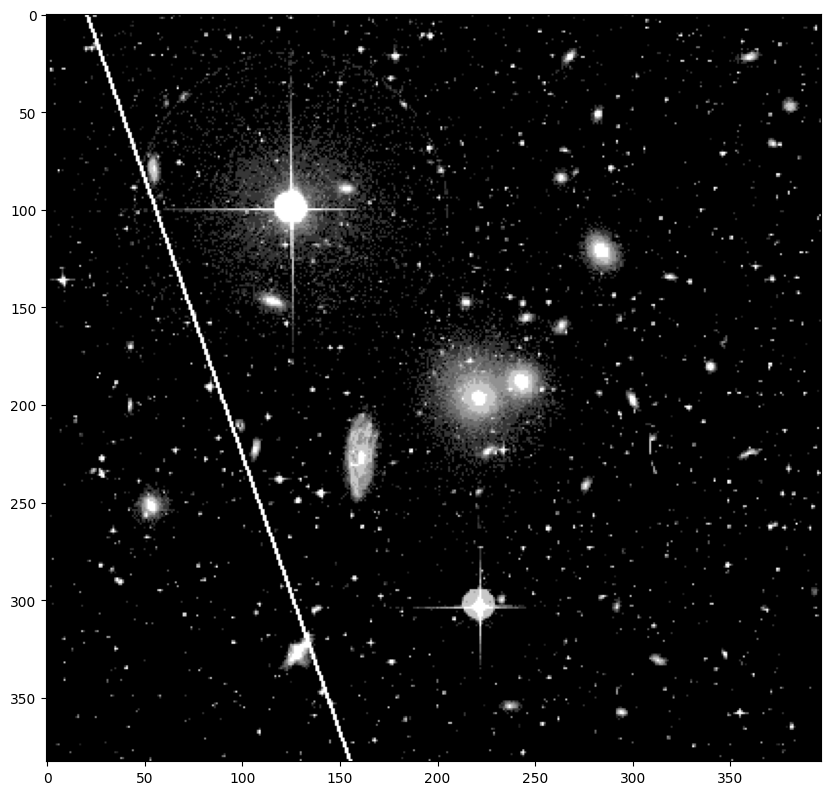

In [ ]:
file_path = "hydra_poss.gif"
I_clean = Image.open(file_path).convert('L')
draw = ImageDraw.Draw(I_clean)

line_color = 255

#coordinates of the line
x1, y1 = 20 , 0
x2, y2 = 160, 397

draw.line((x1, y1, x2, y2), fill=line_color, width=2)

I_trail = np.array(I_clean, dtype=np.float32)

fig = plt.subplots(1,1,figsize=(10,10))
plt.imshow(I_trail,cmap="gray")

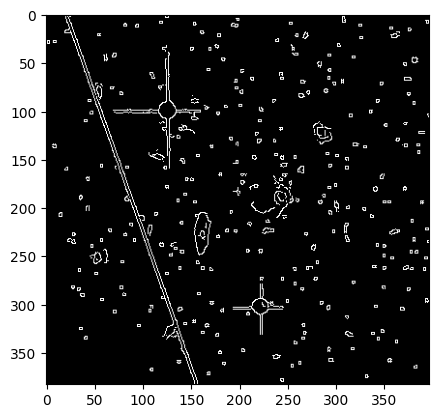

In [ ]:
# We are applying Gaussian Blur to the image before applying Canny edge map
blur_img = cv2.GaussianBlur(I_trail, (5, 5), 0)
I_trail_blur = np.uint8(blur_img) 
# Here, we apply Canny edge detector to our image since our Hough function takes Canny edge maps as input
canny_img = cv2.Canny(I_trail_blur, 100, 200)
plt.imshow(canny_img, cmap="gray")

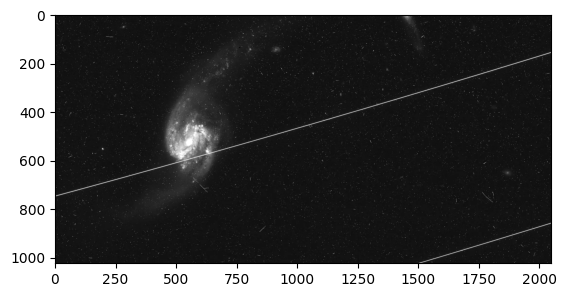

In [ ]:
# Repeating the same steps for image1
img1 = Image.open("image1.png").convert('L')
I_trail_img1 = np.array(img1, dtype=np.float32)
plt.imshow(I_trail_img1, cmap="gray")

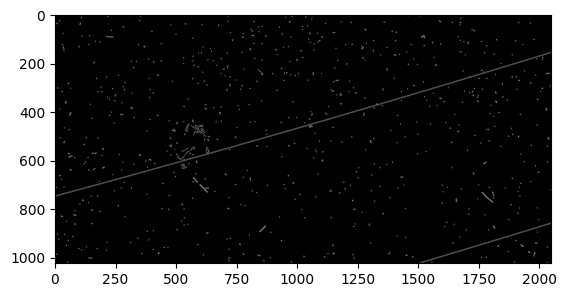

In [ ]:
blur_img1 = cv2.GaussianBlur(I_trail_img1, (5, 5), 0)
I_trail_img1_blur = np.uint8(blur_img1)
canny_img1 = cv2.Canny(I_trail_img1_blur, 100, 200)
plt.imshow(canny_img1, cmap="gray")

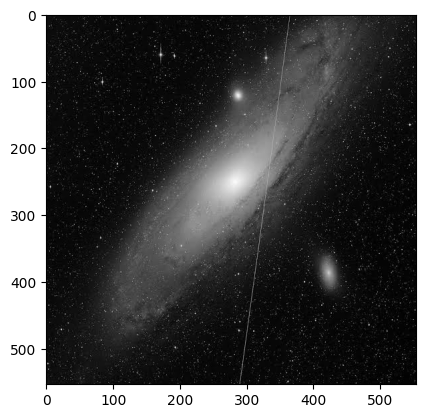

In [ ]:
# Repeating the same steps for image2
img2 = Image.open("image2.jpg").convert('L')
I_trail_img2 = np.array(img2, dtype=np.float32)
plt.imshow(I_trail_img2, cmap="gray")

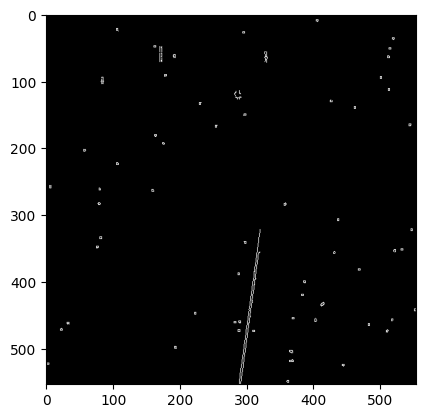

In [ ]:
blur_img2 = cv2.GaussianBlur(I_trail_img2, (5, 5), 0)
I_trail_img2_blur = np.uint8(blur_img2)
canny_img2 = cv2.Canny(I_trail_img2_blur, 100, 200)
plt.imshow(canny_img2, cmap="gray")

#**3) Hough function to detect straight lines**

In [ ]:
def hough_line(img, angle_step=1, lines_are_white=True, value_threshold=5):
    """
    Hough transform for lines
    Input:
    img - 2D binary image with nonzeros representing edges
    angle_step - Spacing between angles to use every n-th angle
                 between -90 and 90 degrees. Default step is 1.
    lines_are_white - boolean indicating whether lines to be detected are white
    value_threshold - Pixel values above or below the value_threshold are edges
    """
    # Rho and Theta ranges
    thetas = np.deg2rad(np.arange(-90.0, 90.0, angle_step))
    width, height = img.shape
    diag_len = int(round(np.sqrt(width * width + height * height)))
    rhos = np.linspace(-diag_len, diag_len, diag_len * 2)

    # Cache some resuable values
    cos_t = np.cos(thetas)
    sin_t = np.sin(thetas)
    num_thetas = len(thetas)

    # Hough accumulator array of theta vs rho
    accumulator = np.zeros((2 * diag_len, num_thetas), dtype=np.uint8)
    # (row, col) indexes to edges
    are_edges = img > value_threshold if lines_are_white else img < value_threshold
    y_idxs, x_idxs = np.nonzero(are_edges)

    # Vote in the hough accumulator
    for i in range(len(x_idxs)):
        x = x_idxs[i]
        y = y_idxs[i]

        for t_idx in range(num_thetas):
            # Calculate rho. diag_len is added for a positive index
            rho = diag_len + int(round(x * cos_t[t_idx] + y * sin_t[t_idx]))
            accumulator[rho, t_idx] += 1
            
    """
    Returns:
    accumulator - 2D array of the hough transform accumulator
    theta - array of angles used in computation, in radians.
    rhos - array of rho values. Max size is 2 times the diagonal
           distance of the input image.
    """

    return accumulator, thetas, rhos

#**4) Printing the (r, theta) parameters of the strongest line detected**

In [ ]:
accumulator, thetas, rhos = hough_line(canny_img)

# Find maximum value in accumulator array
max_value_idx = np.argmax(accumulator)
max_rho_idx, max_theta_idx = np.unravel_index(max_value_idx, accumulator.shape)
max_rho, max_theta = rhos[max_rho_idx], thetas[max_theta_idx]

# Print detected line
print(f"Detected line: rho={max_rho}, theta={np.rad2deg(max_theta)}")

Detected line: rho=17.51586582048958, theta=-20.0


#**5) Showing the detected line**

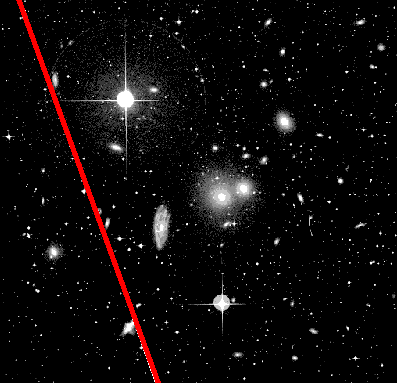

In [ ]:
x1 = 0
y1 = int((max_rho - x1 * np.cos(max_theta)) / np.sin(max_theta))
x2 = I_trail.shape[1]
y2 = int((max_rho - x2 * np.cos(max_theta)) / np.sin(max_theta))

# Draw line on image
img_with_line = cv2.cvtColor(I_trail, cv2.COLOR_GRAY2BGR)
cv2.line(img_with_line, (x1, y1), (x2, y2), (0, 0, 255), 4)


cv2_imshow(img_with_line)
cv2.waitKey(0)
cv2.destroyAllWindows()

#**6) Showing the final image with detected line removed**

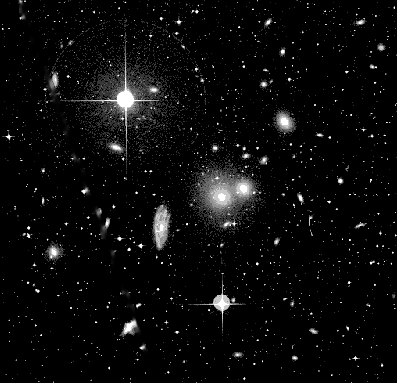

In [ ]:
mask = np.uint8(np.zeros_like(I_trail))
cv2.line(mask, (x1, y1), (x2, y2), 255, 5)

# Apply inpainting algorithm to remove line
img_without_line = cv2.inpaint(I_trail, mask, 3, cv2.INPAINT_NS)


# Show image with detected line removed
cv2_imshow(img_without_line)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [ ]:
#Repeating the same for image 2
accumulator, thetas, rhos = hough_line(canny_img2)

# Find maximum value in accumulator array
max_value_idx = np.argmax(accumulator)
max_rho_idx, max_theta_idx = np.unravel_index(max_value_idx, accumulator.shape)
max_rho, max_theta = rhos[max_rho_idx], thetas[max_theta_idx]

# Print detected line
print(f"Detected line: rho={max_rho}, theta={np.rad2deg(max_theta)}")

Detected line: rho=362.7316293929712, theta=8.0


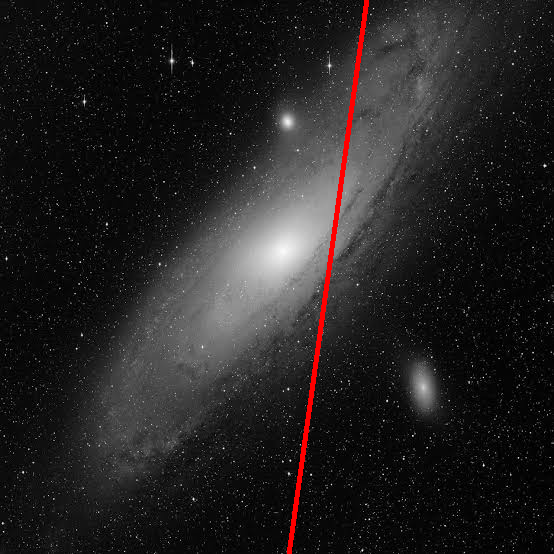

In [ ]:
x1 = 0
y1 = int((max_rho - x1 * np.cos(max_theta)) / np.sin(max_theta))
x2 = I_trail_img2.shape[1]
y2 = int((max_rho - x2 * np.cos(max_theta)) / np.sin(max_theta))

# Draw line on image
img_with_line = cv2.cvtColor(I_trail_img2, cv2.COLOR_GRAY2BGR)
cv2.line(img_with_line, (x1, y1), (x2, y2), (0, 0, 255), 4)


cv2_imshow(img_with_line)
cv2.waitKey(0)
cv2.destroyAllWindows()

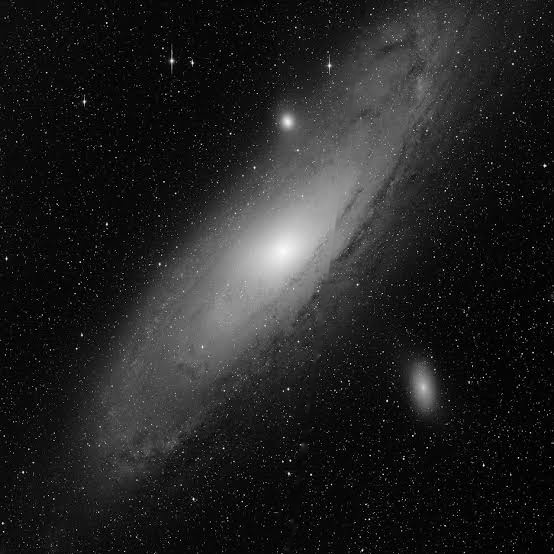

In [ ]:
mask = np.uint8(np.zeros_like(I_trail_img2))
cv2.line(mask, (x1, y1), (x2, y2), 255, 5)

# Apply inpainting algorithm to remove line
img_without_line = cv2.inpaint(I_trail_img2, mask, 3, cv2.INPAINT_NS)


# Show image with detected line removed
cv2_imshow(img_without_line)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [ ]:
# Repeating the same for image 1
accumulator, thetas, rhos = hough_line(canny_img1)

# Find maximum value in accumulator array
max_value_idx = np.argmax(accumulator)
max_rho_idx, max_theta_idx = np.unravel_index(max_value_idx, accumulator.shape)
max_rho, max_theta = rhos[max_rho_idx], thetas[max_theta_idx]

# Print detected line
print(f"Detected line: rho={max_rho}, theta={np.rad2deg(max_theta)}")

Detected line: rho=749.6636820266431, theta=73.0


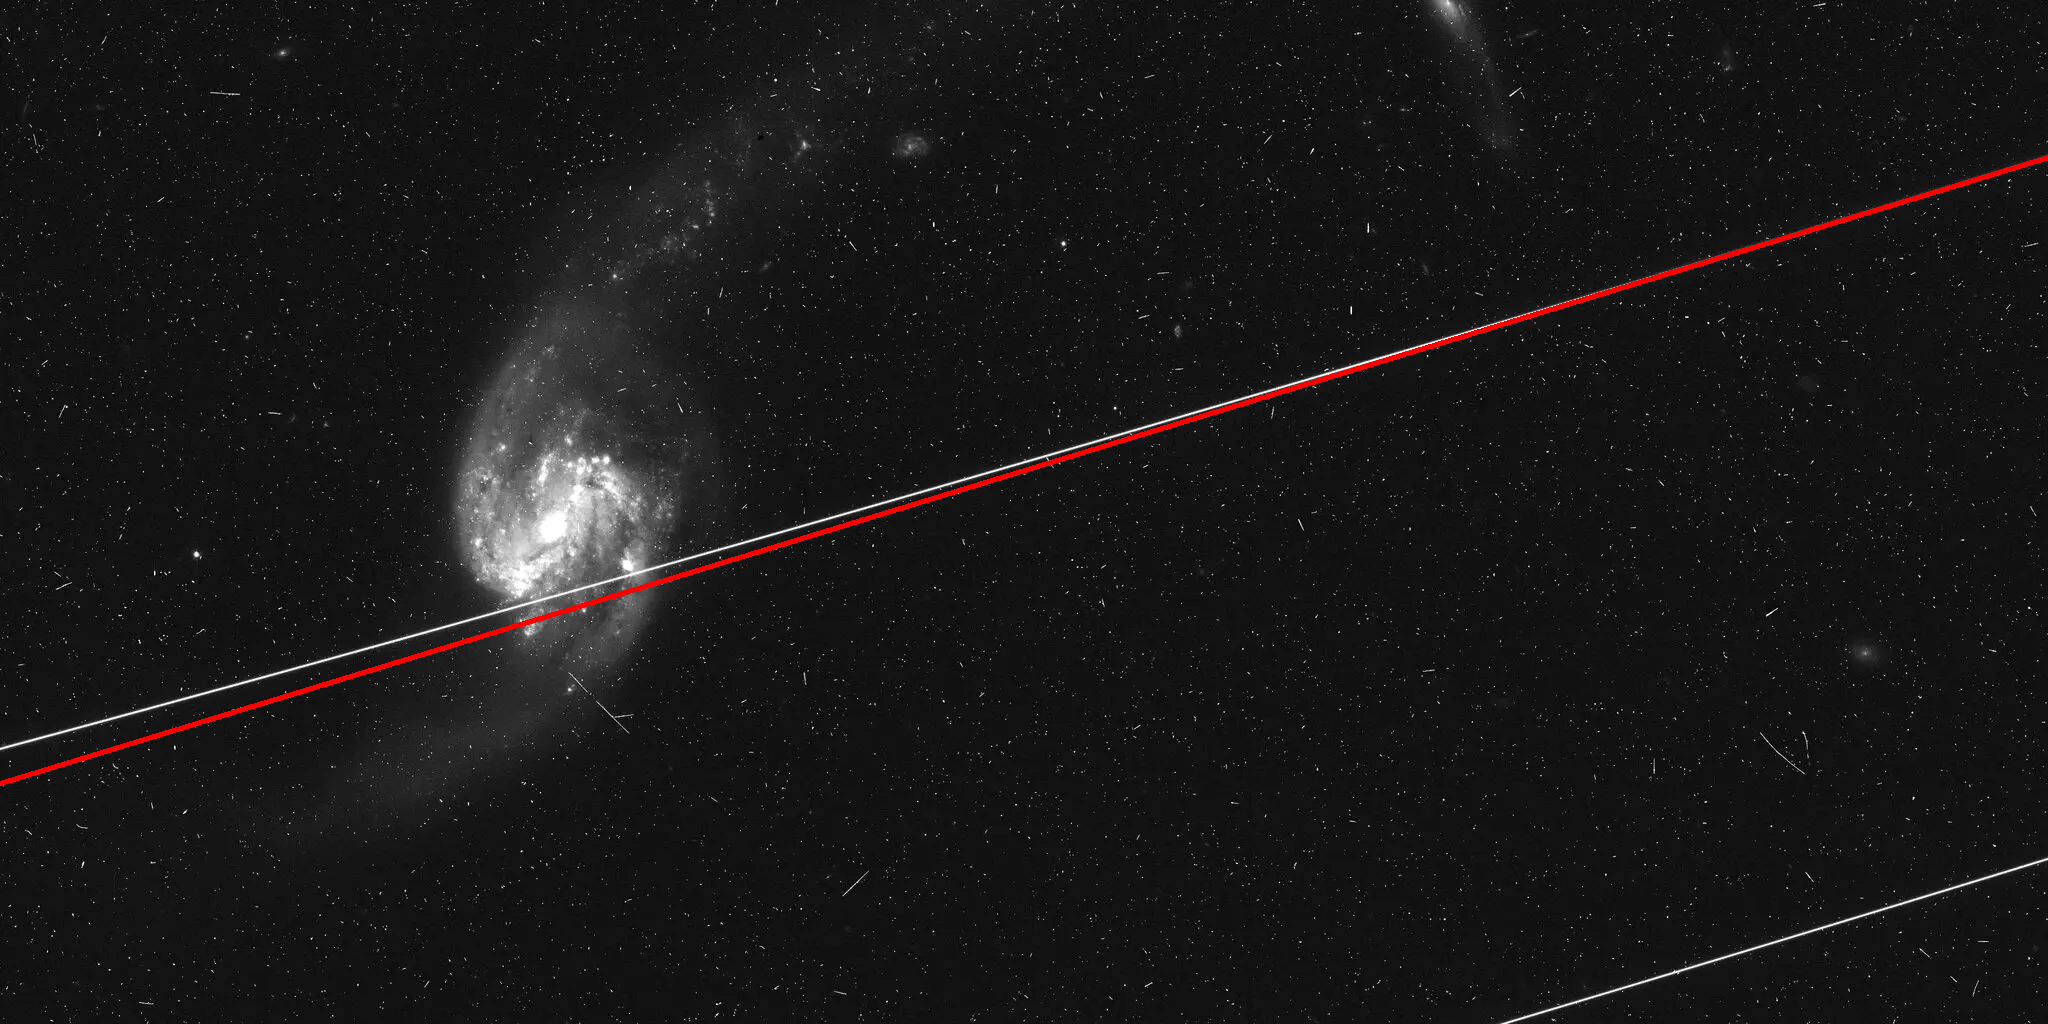

In [ ]:
x1 = 0
y1 = int((max_rho - x1 * np.cos(max_theta)) / np.sin(max_theta))
x2 = I_trail_img1.shape[1]
y2 = int((max_rho - x2 * np.cos(max_theta)) / np.sin(max_theta))

# Draw line on image
img_with_line = cv2.cvtColor(I_trail_img1, cv2.COLOR_GRAY2BGR)
cv2.line(img_with_line, (x1, y1), (x2, y2), (0, 0, 255), 4)


cv2_imshow(img_with_line)
cv2.waitKey(0)
cv2.destroyAllWindows()